In [1]:
cd ../../src

/Users/in-divye.singh/Documents/Projects/MIC_predictor/src


In [2]:
import biovec
import numpy as np
import pandas as pd
from itertools import chain, combinations
from collections import Counter

from utils import *

from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

from Bio.SeqUtils.ProtParam import ProteinAnalysis

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)

In [5]:
avp_ic50 = pd.read_csv("../data/raw/AVP-IC50Pred_train.csv")
ha_avp = pd.read_csv("../data/raw/HA_AVP.csv")

In [6]:
df = pd.concat([avp_ic50[['Sequence','MIC']], ha_avp], axis=0).drop_duplicates(['Sequence']).reset_index(drop=True)
df = sequence_filtering(df)

In [7]:
df2 = df[df['MIC'] >= 1e-3].reset_index(drop=True)

In [8]:
df2

,Sequence,MIC
0,AAQRRGRVGRNPNQVGD,442.00000
1,HRILARIRQMMT,435.50000
2,RNPSQVGD,383.00000
3,RVGRNPNQVGD,374.00000
4,AAQRRGRIGRNPSQVGD,358.00000
...,...,...
702,SLDQINVTFLDLEYEMKKLEEAIKKLEESYIDLKEL,0.00130
703,NGAICWGPCPTAFRQIGNCGHFKVRCCKIR,0.11515
704,CFPYITRPGTYHDWWYTRKNRQ,0.30000
705,YTSLIHSLIEESQNQQEKNEQELLELDKWASLWNWF,0.01131


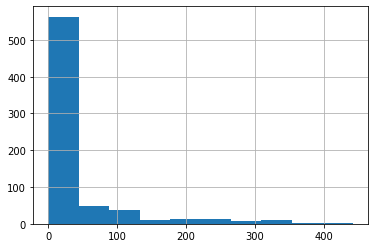

In [9]:
df2['MIC'].hist()

In [10]:
df2['pIC50'] = df2['MIC'].apply(lambda x: -np.log(x*1e-6))

In [11]:
df2

,Sequence,MIC,pIC50
0,AAQRRGRVGRNPNQVGD,442.00000,7.724201
1,HRILARIRQMMT,435.50000,7.739016
2,RNPSQVGD,383.00000,7.867476
3,RVGRNPNQVGD,374.00000,7.891255
4,AAQRRGRIGRNPSQVGD,358.00000,7.934978
...,...,...,...
702,SLDQINVTFLDLEYEMKKLEEAIKKLEESYIDLKEL,0.00130,20.460902
703,NGAICWGPCPTAFRQIGNCGHFKVRCCKIR,0.11515,15.977030
704,CFPYITRPGTYHDWWYTRKNRQ,0.30000,15.019483
705,YTSLIHSLIEESQNQQEKNEQELLELDKWASLWNWF,0.01131,18.297579


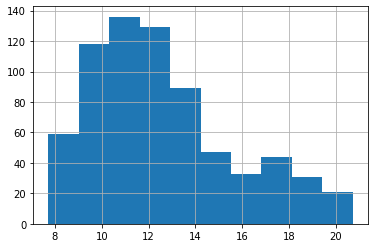

In [12]:
df2['pIC50'].hist()

In [13]:
def get_physicochemical_properties(df):
    params = ['aromaticity', 'helix', 'turn', 'sheet', 'gravy', 'net_charge_at_pH7point4']

    prop = []
    for seq in df.Sequence:
        X = ProteinAnalysis(seq)
        aromaticity = X.aromaticity()
        sec_struc = X.secondary_structure_fraction()
        helix = sec_struc[0]
        turn = sec_struc[1]
        sheet = sec_struc[2]
        gravy = X.gravy() # hydrophobicity related
        net_charge_at_pH7point4 = X.charge_at_pH(7.4)

        prop.append([aromaticity, helix, turn, sheet, gravy, net_charge_at_pH7point4])
    return pd.DataFrame(prop, columns=params)

In [14]:
dipep_freq = reduce_by_kmer_frequency(df2, kmer=2)

In [15]:
uniprot_embedding = biovec.models.load_protvec("../data/embeddings/uniprot__kmer_3_contextWindow_10_vector_100_reduction_None")

avg_protvec = convert_sequences_to_avg_vectors(df['Sequence'], uniprot_embedding, kmer=3)
avg_protvec = avg_protvec.reset_index(drop=True)

/Users/in-divye.singh/anaconda3/envs/life-science/lib/python3.6/site-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
Creating vectors: 100%|██████████| 712/712 [00:00<00:00, 1024.33sequence/s]


In [16]:
physicochemical_prop = get_physicochemical_properties(df2)

In [17]:
X = pd.concat([dipep_freq, physicochemical_prop[['turn']]], axis=1)

In [18]:
y = df2[['pIC50', 'MIC']]

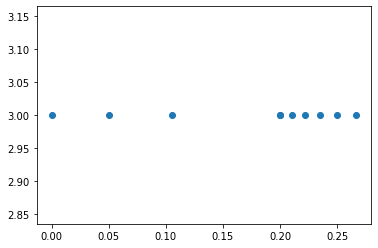

In [103]:
val=3
mic_4 = df2[df2['MIC'] == val]['MIC']
mic_4_mask = (df2['MIC'] == val)
X_mic_4 = X[mic_4_mask]
plt.scatter(x=X_mic_4['turn'], y = df2[mic_4_mask]['MIC'], label='turn')
#plt.scatter(x=X_mic_4['DC'], y = df2[mic_4_mask]['MIC'], label='DC')

In [79]:
from scipy.stats import pearsonr, spearmanr

In [99]:
for dipep in dipep_freq.columns:
    p_corr = pearsonr(dipep_freq[dipep], df2['MIC'])
    if p_corr[0] > 0.2:
        print(dipep, pearsonr(dipep_freq[dipep], df2['MIC']))

AC (0.2397797778546926, 1.0554356511724987e-10)
AG (0.36470471724058984, 1.1531429230889437e-23)
AY (0.23834591637406297, 1.371623142740871e-10)
CW (0.274812629155201, 1.0232526899059378e-13)
EF (0.21581230318052952, 6.766308364639767e-09)
GD (0.302715739521357, 1.8934264818384592e-16)
GI (0.25593912890568765, 4.893352805031891e-12)
GR (0.21420051620804692, 8.803983998282423e-09)
KQ (0.20609700385206253, 3.2062169415819284e-08)
PN (0.27754697239082543, 5.695360905446985e-14)
QV (0.250555899615188, 1.3947137437581823e-11)
RN (0.21952645008824573, 3.6600573153266727e-09)
TA (0.23518810410077803, 2.4281680131585375e-10)
VG (0.2630478798362398, 1.1819004191476415e-12)
WW (0.23057549362511778, 5.511060658526512e-10)


/Users/in-divye.singh/anaconda3/envs/life-science/lib/python3.6/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [95]:
for dipep in dipep_freq.columns:
    s_corr = spearmanr(dipep_freq[dipep], df2['MIC'])
    if s_corr.correlation > 0.15:
        print(dipep, s_corr)

AG SpearmanrResult(correlation=0.22913964248728924, pvalue=7.087719746558926e-10)
PN SpearmanrResult(correlation=0.19802433357813592, pvalue=1.1040798001872922e-07)


/Users/in-divye.singh/anaconda3/envs/life-science/lib/python3.6/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/in-divye.singh/anaconda3/envs/life-science/lib/python3.6/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/in-divye.singh/anaconda3/envs/life-science/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/Users/in-divye.singh/anaconda3/envs/life-science/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/Users/in-divye.singh/anaconda3/envs/life-science/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


In [91]:
from sklearn.manifold import TSNE

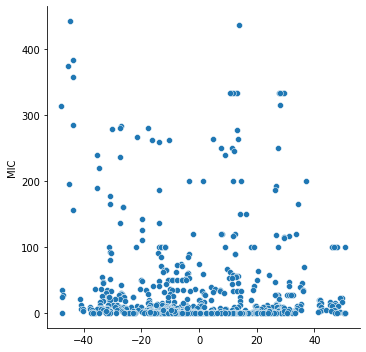

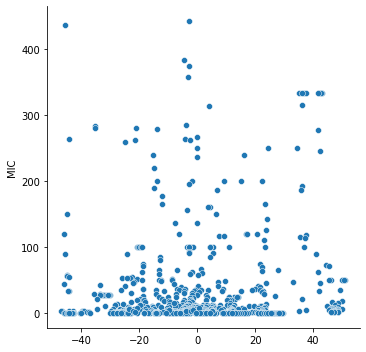

In [60]:
tsne = TSNE(n_components=2, perplexity=10.0, n_iter=500)
X_trans = tsne.fit_transform(X)
sns.relplot(x=X_trans[:,0], y = df2['MIC'])
sns.relplot(x=X_trans[:,1], y = df2['MIC'])

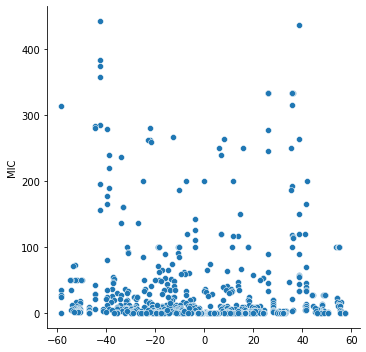

In [63]:
tsne = TSNE(n_components=1, perplexity=10.0, n_iter=500)
X_trans_2 = tsne.fit_transform(X)
sns.relplot(x=X_trans_2.squeeze(), y = df2['MIC'])